### Pricing an Asian Option with several variance reduction techniques

This notebook is sample code on using a number of variance reduction techniques to see how accurate an estimate we can get for the price of a discretely monitored Asian Option.

The value of an Asian call option, denoted by $ V(t, S_t) $ is defined as $ \mathbb{E}^\mathbb{Q} \left[ e^{-r(T-t)}\max(\bar{S} - K, 0) \right | \mathcal{F}_t] $

where $\bar{S} := \frac{1}{n} \Sigma_{i=1}^{n} S(t_i)$.

Note that discretely monitoring is easier to work with when simulating as everything is stored discretely, rather than continuously.

For this example, let's define the process such that $S(0) = 50, r = 0.05, \sigma = .03, K = 50,$ and $T = 0.25$. Moreover, we define $m = 90$ and $t_i = iT/m$ for $i = 1, 2, 3, ... , m-1, m$

Thus, this example will price an Asian option whose average value is computed as an arithmetic average of its daily price, likely a closing price tracked at 4 p.m., but it could be anything that the contract terms specify as exotics are not usually on an exchange and are instead traded OTC.

We will explore the following:


1. Standard Monte Carlo Simulation
2. Antithetic Variates
3. Terminal stratification on $S(T)$ with proportional stratification and $d = 10$ equiprobable strata.
4. Post stratification on $\tilde{S}$ where $\tilde{S}$ is the *geometric* mean of $S(t_i)$.
5. Latin Hypercube sampling.

For an exercise in importance sampling, conditional monte carlo, or control variates, see other code samples.

In [1]:
import numpy as np
import scipy.stats as sp
import matplotlib.pyplot as plt

#Define parameters
T = 0.25
r = 0.05
sigma = 0.3
S0 = 50
K = 50
reps = 10000 #number of monte carlo iterations.
m = 90

#Storage
#Each row is a monte carlo iteration
# each column is an individual time step. I.e. reading left to right on an excel spreadsheet, we track a path
# TODO: Revise this Explanation: we have m+1 time steps. index 0 is t = 0, index 1 is t = T/m, ... index m-1 is (m-1)*T/m, index
#X = np.ndarray(shape = (reps, m))
#S = np.ndarray(shape = (reps, m))
#S[:, 0] = S0
#set seed
np.random.seed(seed=489230)

t = np.arange(start = T/m, stop = T + T/m, step = T/m)
#Sample from the standard normal distribution. Note that we sample 10,0000 x 90 normal random variables. That is, one normal for each step for each monte carlo iteration.
Z = sp.norm.rvs(loc = 0, scale = 1, size = (reps,m))
#W represents the standard Brownian Motion
W = np.cumsum(np.sqrt(T/m) * Z, axis = 1) # standard BM
#X represents the drifted and diffused Brownian Motion, i.e. Wiener Process
X = (r - sigma**2/2) * T / m + sigma * W
#X[:,:] = (r - sigma**2/2) * T / 90 * np.repeat(a = np.arange(start = 0, stop = T, step = T/m) , repeats = reps, axis = 1) + sigma * W # BM with drift & diffusion
#Construct the Geometric Brownian Motion
S = S0*np.exp(X) # GBM

# Calculate arithmetic and geometric means
Sbar = np.mean(S, 1)
Stilde = sp.gmean(S, 1)



Let's verify that our simulation made sense by looking at some plots.

Text(0, 0.5, 'Value of BM')

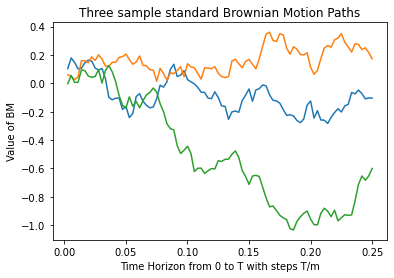

In [59]:
plt.plot(t, W[0, :])
plt.plot(t, W[1, :])
plt.plot(t, W[2, :])
plt.title("Three sample standard Brownian Motion Paths")
plt.xlabel("Time Horizon from 0 to T with steps T/m")
plt.ylabel("Value of BM")


Text(0, 0.5, 'Value')

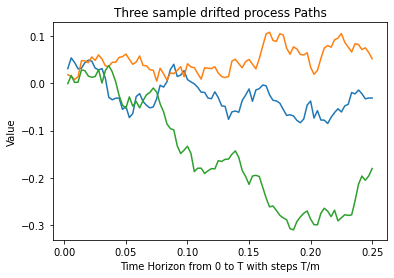

In [60]:
plt.plot(t, X[0, :])
plt.plot(t, X[1, :])
plt.plot(t, X[2, :])
plt.title("Three sample drifted process Paths")
plt.xlabel("Time Horizon from 0 to T with steps T/m")
plt.ylabel("Value")

These two plots look good. We expect the plots to look the same since $X$ is just scaled and shifted from $W$. The real magic is the plots of $S$

Text(0, 0.5, 'Value')

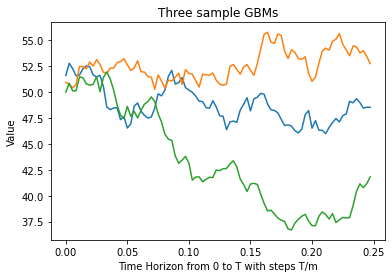

In [52]:
plt.plot(t, S[0, :])
plt.plot(t, S[1, :])
plt.plot(t, S[2, :])
plt.title("Three sample GBMs")
plt.xlabel("Time Horizon from 0 to T with steps T/m")
plt.ylabel("Value")

These plots look good. Before we move forward though, one point of clarification. If we look closely, we see that the plots do not start at the same value, which is nonintuitive.

This is because of how we defined our time axis. If we use $m = 90$ steps, so that each iteration is one day, we will either be excluding the value at $ t = 0 $, or excluding the terminal value at $t = T$. Obviously we do not want to exclude the terminal value when we simulate. That is why we exclude the value at $t = 0$.

For cleaner plots, it is advisable to go up to $m + 1$ individual time values, while keeping the step size the same. See the code cell below to see how the generation is performed.

In [74]:
excluding_t_0 = np.linspace(start = T/m, stop = T, num = m)
including_t_0 = np.linspace(start = 0, stop = T, num = m+1)

Now we continue by computing the price and the corresponding 95% Confidence Interval for standard Monte Carlo Simulation.

In [8]:
# (a) Monte Carlo

# Calculate price estimate and 95% CI
Y = np.exp(-r*T) * np.maximum(Sbar - K, 0)
Ybar_MC = np.mean(Y);
s_MC = np.std(Y);
CI_MC = [Ybar_MC - 1.96*s_MC/np.sqrt(reps), Ybar_MC + 1.96*s_MC/np.sqrt(reps)]
print(f'Part 1: Monte Carlo estimator is {Ybar_MC:.4f} with 95 percent CI is [{CI_MC[0]:.4f}, {CI_MC[1]:.4f}]')

Part 1: Monte Carlo estimator is 1.8246 with 95 percent CI is [1.7710, 1.8783]


2. Antithetic Variates.

Antithetic Variates are quite simple. Suppose random variable $Y$ and random variable ${Y}^\prime$ are identically distributed, but are *not necessarily independent.* This is important as we will see at the end of the calculation.

Then we have:

$\mathbb{E} \left[ \frac{Y+ Y^\prime}{2} \right] = \mathbb{E} \left[ Y  \right]$

That is, if we take 50% of each random variable, we can get the same expectation. In the code below, I refer to this as Y_paired.

When we compute the variance, we observe the following:
$Var \left[ \frac{Y+ Y^\prime}{2} \right] = \frac{1}{4} \left[ Var(Y) + Var(Y^\prime) + 2Cov(Y, Y^\prime)  \right]$

Since $Y$ and ${Y}^\prime$ are identically distributed, as per how we defined the variables, their variance is the same and so we can combine the first two terms. Distributing the constant, we are left with
$Var \left[ \frac{Y+ Y^\prime}{2} \right] = \frac{1}{2} \left( Var(Y) + Cov(Y, Y^\prime) \right)$

Thus, if the variables are independent, we have halved the variance. However, if they are negatively correlated, we have an even greater reduction in variance.

So in our example, how we get negatively correlated variables? It's very easy. Take the first half of our variables $Z$, the independently drawn standard normal variables. Then multiply them by $-1$ and use that set as the second half. Draw 0 is perfectly negatively correlated with draw reps/2, which in this case would be 5000; draw 1 is perfectly negatively correlated with draw 5001, and so on.

To drive this point home, below we also plot two antithetic paths.

Text(0.5, 1.0, 'Two Antithetic Sample Paths')

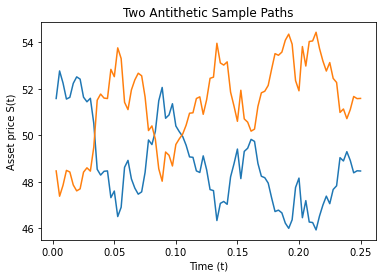

In [32]:
# 2. Antithetic with random walk construction

# Take first 5000 sample paths and create antithetic pairs
Z_anti = np.concatenate((Z[0:reps//2, :], -Z[0:reps//2, :]), axis = 0)
W_anti = np.cumsum(np.sqrt(T/m) * Z_anti, axis = 1)
X_anti = (r - sigma**2/2) * T / m + sigma * W_anti
S_anti = S0*np.exp(X_anti);


#Plot 2 antithetic sample paths

plt.plot(t, np.transpose(S_anti[[0,5000],:]))
plt.xlabel('Time (t)')
plt.ylabel('Asset price S(t)')
plt.title('Two Antithetic Sample Paths')


In [64]:
# Calculate payoffs and average the antithetic pairs
Sbar_anti = np.mean(S_anti, 1)
Stilde_anti = sp.gmean(S_anti, 1)

Y_anti = np.exp(-r*T) * np.maximum(Sbar_anti - K, 0)
#Y_paired = (Y_anti(1:(reps/2),:) + Y_anti((reps/2+1):reps,:))/2
Y_paired = (Y_anti[0:reps//2] + Y_anti[reps//2:]) / 2.0
# Calculate antithetic estimator, 95% CI, and variance reduction
Ybar_anti = np.mean(Y_paired);
s_anti = np.std(Y_paired);
#Note that change from reps to reps/2 when computing square root. We are working with less samples.
CI_anti = [Ybar_anti - 1.96*s_anti/np.sqrt(reps/2), Ybar_anti + 1.96*s_anti/np.sqrt(reps/2)]
print(f'Part 2: The antithetic estimator is {Ybar_anti:.4f} with 95 percent CI is [{CI_anti[0]:.4f}, {CI_anti[1]:.4f}]')

var_red_anti = 1 - (s_anti**2/(reps/2))/(s_MC**2/reps)
print(f'The estimated variance reduction for antithetic variates is {var_red_anti:.2%}.')

Part 2: The antithetic estimator is 1.8646 with 95 percent CI is [1.8241, 1.9052]
The estimated variance reduction for antithetic variates is 42.82%.


## Terminal Stratification

The general set up is as follows. We want to compute $\mu = \mathbb{E}[Y]$ where $Y$ is a real-valued random variable. Now consider $X$, another random variable that is correlated with Y, and define $A_1, A_2, ... , A_d$ to a disjoint partition of the range of $X$. That is,

$range(X) = \bigcup\limits_{i=1}^d  A_i $

Then, we use the law of total expectation (or law of iterated expectation), which, when applied to a disjoint partition is:

$\mathbb{E}[Y] = \sum\limits_{i=1}^d \mathbb{E}[Y | X \in A_i]P[X \in  A_i] = \sum\limits_{i=1}^{d} \mu_i p_i$

We assume that $p_i$ is known and $\mu_i$ is not.

Finally, we estimate $\mu_i$ with $\hat\mu_i = \frac{1}{n_i} \sum\limits_{j=1}^{n_i} Y_{ij}$ In simple English, this means that for the $i$th strata, we estimate its conditional expectation by taking a sum over the number of observations of $Y_{ij}$ in the $i$ th strata, which is $n_i$, where $Y_{i1}, Y_{i2}, ... , Y_{in_i-1}, Y_{in_i}$ are i.i.d. random variables that have the conditional distribution of $Y$ given that $X$ falls in the $i$ th stratum $A_i$.

The final step is to take the sum of the conditional expectations over all the strat to obtain the estimate for the expectation:
$\hat\mu = \sum\limits_{i=1}^{d} \hat\mu_i p_i = \sum\limits_{i=1}^{d} \left( \frac{1}{n_i} \sum\limits_{j=1}^{n_i} Y_{ij} \right) p_i = \frac{1}{n} \sum\limits_{i=1}^{d} \frac{p_i}{q_i}\sum\limits_{j=1}^{n_i} Y_{ij}$

Note that we define $q_i = \frac{n_i}{n}$ as the proportion of observations from the total that are in $A_i$

So there's a lot of math involved but thankfully the math is all algebra and isn't too much of a pain to implement.

Now, for the purpose of this exercise, we have to change one thing: how we generate sample paths. We are going to terminally stratify our sample paths. This makes sense because we want to control the distribution of where the paths end up. For most options, including some path-dependent options (e.g. barrier options), the terminal value, i.e. the value of the underlying at expiration is what we care about. For Asian options, we care about the average value, but the average value is influenced by the terminal value, and is even more so influenced by the path taken to get to that terminal value.

Thus, since we know we have a geometric brownian motion that must start at 0, and must end at a specific value, we no longer use a random walk construction, but instead a brownian bridge construction. The good news here is that Brownian bridge construction is also exact.

In [144]:
# 3. Stratified Sampling on S(T)

d = 10
W_strat = np.zeros(shape = (reps, m))
# Generate stratified terminal values
#Explanation, for each strata, we create a chunk of random uniform variables. These random uniforms are used specifically for the terminal values. They are transformed
#using an inverse normal distribution
for i in range(0, d):
    #Generate uniforms. Only ONE per each monte carlo path in this strata.
    U  = sp.uniform.rvs(loc = 0, scale = 1, size = (reps//d))
    #Now for our Brownian Bridge Construction, write the values to that index
    start = int((i * reps) / d)
    stop = int( (i+1) * reps / d )
    W_strat[start:stop, -1] = np.dot(np.sqrt(T), sp.norm.ppf( (i+U) / d ) )

In [143]:
# Brownian bridge construction to fill out the sample paths
# As an aside, it's usually better to use Brownian Bridge construction when the number of individual time steps is a power of 2 (2, 4, 8, 16, 32, ... 1024, 2048, ...)
# But it can still be done for irregular amounts like m = 90

times = (T/m) * [0:m]
Z_strat = normrnd(0,1,reps,m-1);
for j in range(0, m-1):

    W_strat(:,j+1) = (T - times(j+1))/(T - times(j))*W_strat(:,j)
    + (times(j+1) - times(j))/(T - times(j))*W_strat(:,m+1)
    + sqrt((T - times(j+1))*(times(j+1)-times(j))/(T - times(j))).*Z_strat(:,j);


X_strat = (r-sigma^2/2)*repmat(times,reps,1) + sigma*W_strat; % BM with drift and diffusion
S_strat = S0*exp(X_strat); % GBM


array([-1.02397212, -1.65831161, -0.83471253, ...,  0.76902485,
        1.18030609,  1.01251773])

In [147]:
times = (T/m) * np.arange(0, m)

In [149]:
len(times)

90

In [91]:
type(x)

int